# Chalk Extraction Experiment

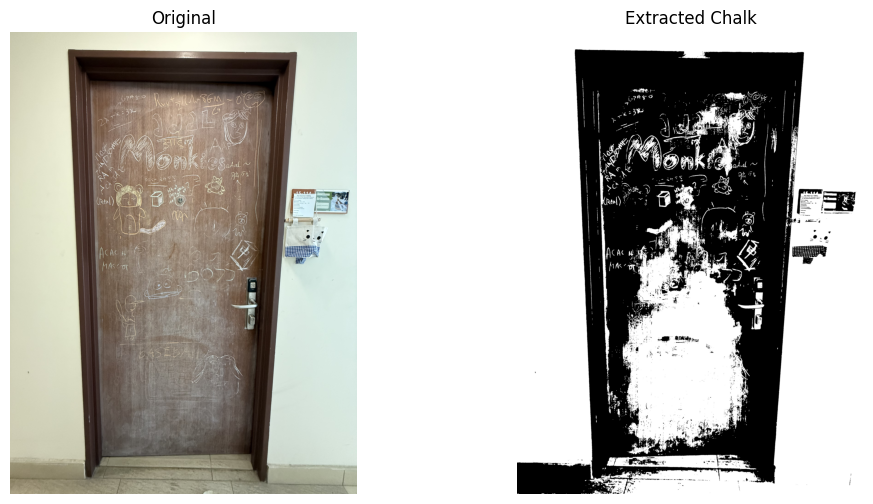

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_chalk_hsv(image_path):
    img = cv2.imread(image_path)
    
    # 1. Convert to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # 2. Define ranges (Adjust these if your result is empty!)
    lower_white = np.array([0, 0, 100])
    upper_white = np.array([180, 50, 255])
    
    # 3. Create Mask
    mask = cv2.inRange(hsv, lower_white, upper_white)
    
    # 4. Clean up noise
    kernel = np.ones((3,3), np.uint8) # Increased kernel size slightly for better noise removal
    clean_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    return img, clean_mask

# --- Run and Display ---
original, result = extract_chalk_hsv("IMG_3104.jpeg")

# Set up matplotlib figure
plt.figure(figsize=(12, 6))

# Plot Original (Convert BGR to RGB for matplotlib)
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")

# Plot Result (Tell matplotlib this is a grayscale image)
plt.subplot(1, 2, 2)
plt.imshow(result, cmap='gray')
plt.title("Extracted Chalk")
plt.axis("off")

plt.show()

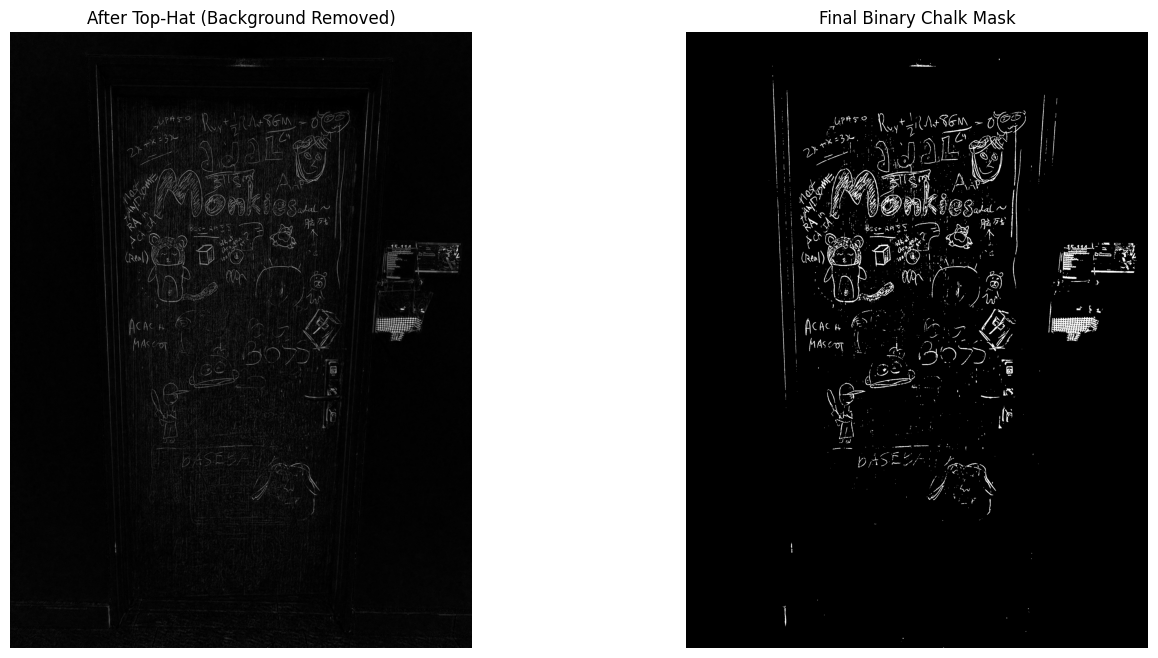

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_chalk_tophat(image_path):
    # Load in Grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # 1. Define a kernel size slightly larger than the thickness of chalk lines
    # Increase this if your chalk lines are very thick
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    
    # 2. Apply Top-Hat
    # This isolates small bright features (chalk) from dark backgrounds (door)
    tophat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)
    
    # 3. Use Otsu's Thresholding instead of a fixed value (30)
    # This automatically finds the best threshold for the specific photo
    _, binary = cv2.threshold(tophat, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 4. Clean up stray noise with a small opening operation
    clean_kernel = np.ones((2,2), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, clean_kernel)
    
    return tophat, binary

# --- Run and Display ---
# Make sure the filename matches your uploaded file
raw_tophat, final_result = extract_chalk_tophat("IMG_3104.jpeg")

plt.figure(figsize=(16, 8))

# Show the "Top-Hat" intermediate step (helpful for debugging)
plt.subplot(1, 2, 1)
plt.imshow(raw_tophat, cmap='gray')
plt.title("After Top-Hat (Background Removed)")
plt.axis("off")

# Show the Final Binary Result
plt.subplot(1, 2, 2)
plt.imshow(final_result, cmap='gray')
plt.title("Final Binary Chalk Mask")
plt.axis("off")

plt.show()

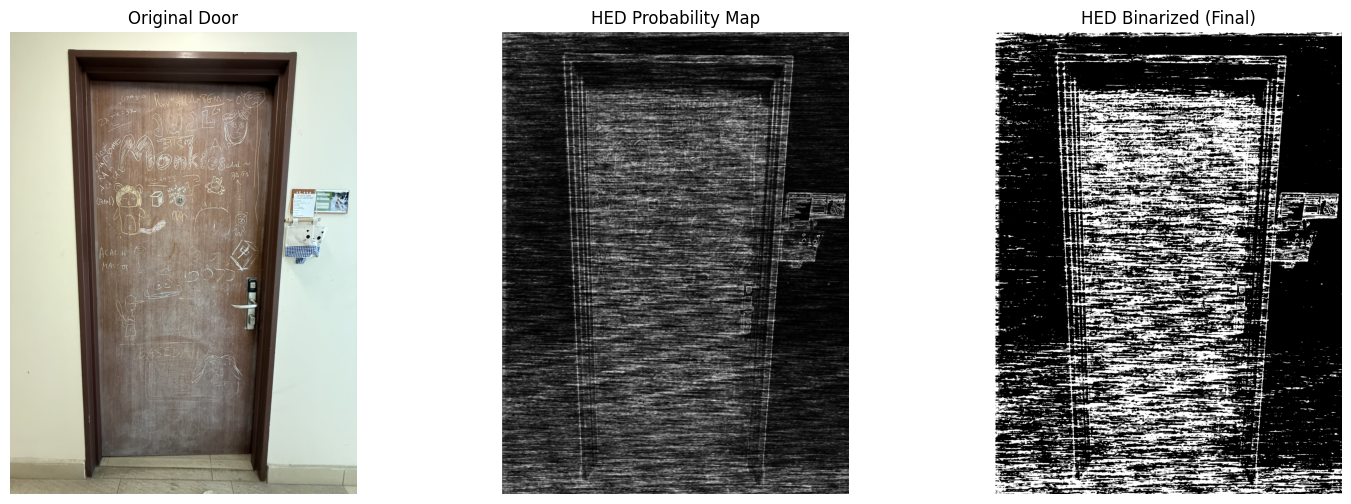

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def extract_chalk_hed(image_path, proto_path="deploy.prototxt", model_path="hed_pretrained_bsds.caffemodel"):
    # Check if files exist to avoid cryptic Caffe errors
    if not os.path.isfile(proto_path) or not os.path.isfile(model_path):
        raise FileNotFoundError("Missing HED model files. Please download deploy.prototxt and caffemodel.")

    # 1. Load the pre-trained HED model
    net = cv2.dnn.readNetFromCaffe(proto_path, model_path)
    
    # 2. Prepare the image
    img = cv2.imread(image_path)
    (H, W) = img.shape[:2]
    
    # Model expects specific mean subtraction for the BSDS500 dataset
    blob = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(W, H),
                                 mean=(104.00698793, 116.66876762, 122.67891434),
                                 swapRB=False, crop=False)
    
    # 3. Run Inference
    net.setInput(blob)
    hed = net.forward()
    
    # 4. Post-process
    hed = cv2.resize(hed[0, 0], (W, H))
    hed = (255 * hed).astype("uint8")
    
    # 5. Optional: Thresholding
    # HED gives a probability map (fuzzy lines). We binarize it for a cleaner "chalk" look.
    _, binary_hed = cv2.threshold(hed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return img, hed, binary_hed

# --- Execute and Display ---
try:
    original, fuzzy_hed, binarized = extract_chalk_hed("IMG_3104.jpeg")

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original Door")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(fuzzy_hed, cmap='gray')
    plt.title("HED Probability Map")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(binarized, cmap='gray')
    plt.title("HED Binarized (Final)")
    plt.axis("off")

    plt.show()
except Exception as e:
    print(f"Error: {e}")

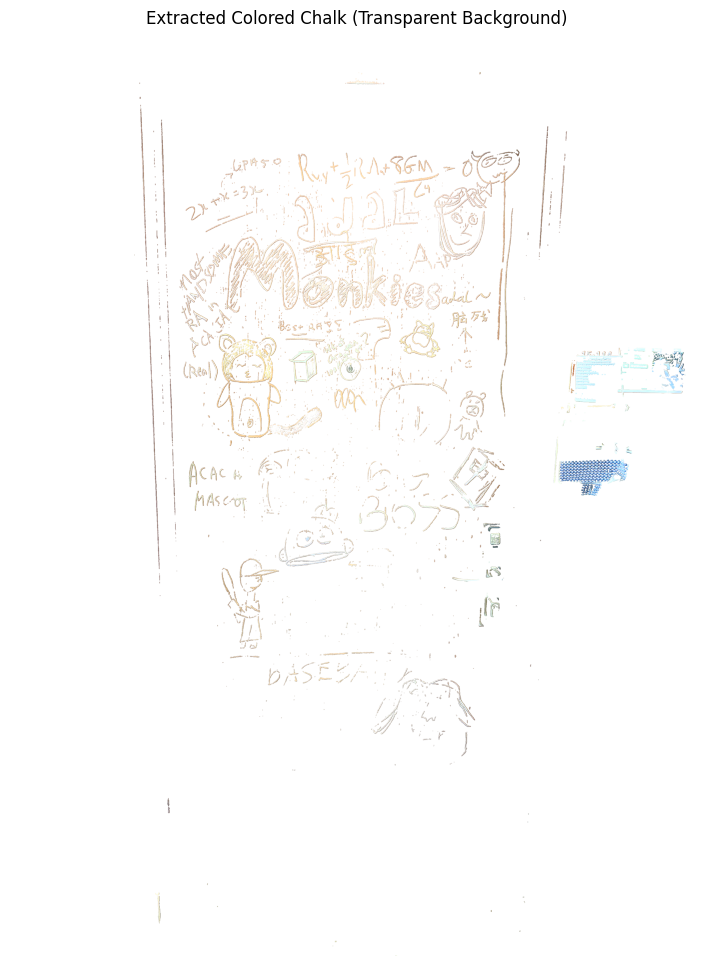

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_colored_chalk_tophat(image_path):
    # 1. Load Original (Color) and Grayscale
    img_color = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    
    # 2. Apply Top-Hat to get the Structure (The "Cookie Cutter")
    # Using the kernel size that worked for you (15x15 or 25x25)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    tophat = cv2.morphologyEx(img_gray, cv2.MORPH_TOPHAT, kernel)
    
    # 3. Threshold to create a Binary Mask
    # Otsu's thresholding works well to separate chalk from noise
    _, mask = cv2.threshold(tophat, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 4. Clean the mask (Remove tiny noise dots)
    clean_kernel = np.ones((2,2), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, clean_kernel)
    
    # 5. Create the Output Image (RGBA = Color + Transparency)
    b, g, r = cv2.split(img_color)
    
    # --- PRO TIP: Color Boosting ---
    # Chalk often picks up the brown door color. Let's boost saturation slightly.
    hsv = cv2.cvtColor(img_color, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    # Multiply saturation by 1.5 (clip at 255) to make colors pop
    s = cv2.multiply(s, 1.5) 
    # Multiply value (brightness) to make it shine
    v = cv2.multiply(v, 1.2) 
    hsv_boosted = cv2.merge([h, s, v])
    boosted_bgr = cv2.cvtColor(hsv_boosted, cv2.COLOR_HSV2BGR)
    b, g, r = cv2.split(boosted_bgr)
    
    # 6. Merge into RGBA
    # The 'mask' becomes our Alpha channel. 
    # Where mask is Black (0), image is Transparent. Where White (255), Opaque.
    rgba = cv2.merge([r, g, b, mask]) # Note: Matplotlib expects RGB, OpenCV uses BGR
    
    return rgba

# --- Run and Display ---
result_rgba = extract_colored_chalk_tophat("IMG_3104.jpeg")

plt.figure(figsize=(12, 12))
# We must tell imshow the image is transparent
plt.imshow(result_rgba) 
plt.title("Extracted Colored Chalk (Transparent Background)")
plt.axis("off")
plt.show()

# To save this for your frontend friend:
# cv2.imwrite("final_chalk.png", cv2.cvtColor(result_rgba, cv2.COLOR_RGBA2BGRA))

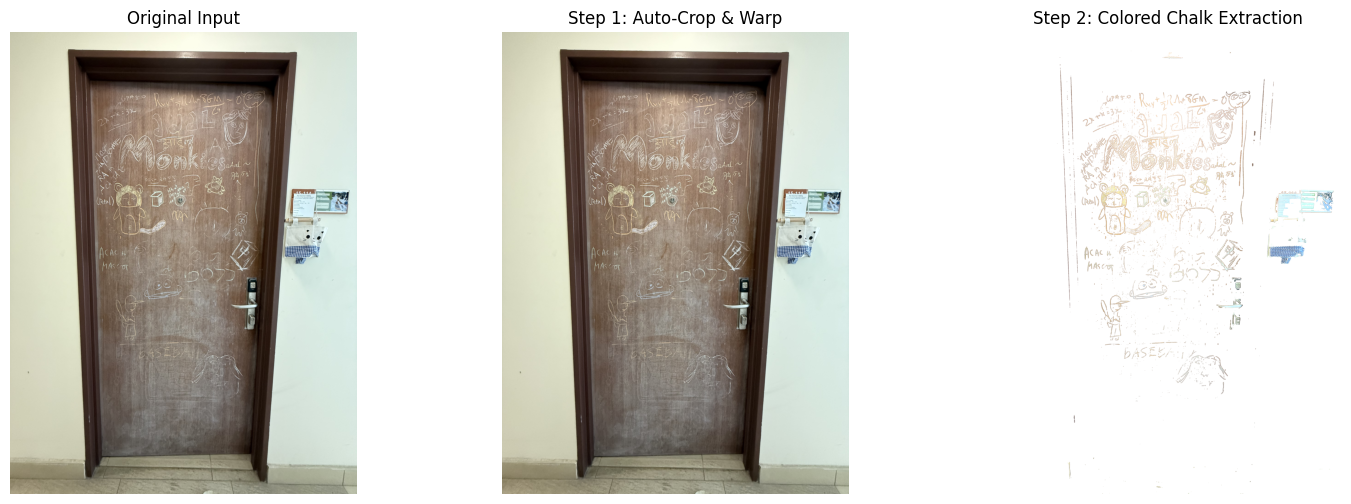

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- HELPER: Order Points (TL, TR, BR, BL) ---
# Necessary for perspective warping to know which corner is which
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)] # Top-Left
    rect[2] = pts[np.argmax(s)] # Bottom-Right
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)] # Top-Right
    rect[3] = pts[np.argmax(diff)] # Bottom-Left
    return rect

# --- HELPER: Perspective Transform ---
def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # Compute width of new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # Compute height of new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # Construct destination points
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # Compute and apply matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

# --- STEP 1: Detect Door & Crop ---
def get_door_only(image_path):
    img = cv2.imread(image_path)
    ratio = img.shape[0] / 500.0
    orig = img.copy()
    
    # Resize for faster detection
    image = cv2.resize(img, (int(img.shape[1] / ratio), 500))
    
    # 1. Edge Detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(gray, 75, 200)

    # 2. Find Contours
    cnts, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5] # Check 5 biggest shapes

    screenCnt = None
    for c in cnts:
        # Approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        # If it has 4 points, we found the door (probably)
        if len(approx) == 4:
            screenCnt = approx
            break

    # 3. Warp Perspective
    if screenCnt is not None:
        warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
        return warped, True # True = Success
    else:
        print("Warning: No clear door found. Using original image.")
        return orig, False

# --- STEP 2: Extract Colored Chalk (The Logic You Liked) ---
def extract_chalk_final(img_color):
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    
    # Top-Hat (Contrast Extraction)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25))
    tophat = cv2.morphologyEx(img_gray, cv2.MORPH_TOPHAT, kernel)
    
    # Thresholding (Create Mask)
    _, mask = cv2.threshold(tophat, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Clean noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((2,2), np.uint8))
    
    # --- Color Boosting ---
    # Separate channels
    b, g, r = cv2.split(img_color)
    
    # Boost Saturation (Make chalk pop)
    hsv = cv2.cvtColor(img_color, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    s = cv2.multiply(s, 1.5) 
    v = cv2.multiply(v, 1.2)
    img_boosted = cv2.cvtColor(cv2.merge([h, s, v]), cv2.COLOR_HSV2BGR)
    b, g, r = cv2.split(img_boosted)

    # Merge with Alpha Channel
    rgba = cv2.merge([r, g, b, mask])
    
    return rgba

# --- EXECUTE PIPELINE ---
# 1. Find and Warp Door
door_warped, success = get_door_only("IMG_3104.jpeg")

# 2. Extract Chalk from the clean door
final_asset = extract_chalk_final(door_warped)

# 3. Display
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(cv2.imread("IMG_3104.jpeg"), cv2.COLOR_BGR2RGB))
plt.title("Original Input")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(door_warped, cv2.COLOR_BGR2RGB))
plt.title("Step 1: Auto-Crop & Warp")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(final_asset)
plt.title("Step 2: Colored Chalk Extraction")
plt.axis("off")

plt.show()

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from rembg import remove # <--- The AI Magic

# --- HELPER: Order Points for Warping ---
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)] # TL
    rect[2] = pts[np.argmax(s)] # BR
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)] # TR
    rect[3] = pts[np.argmax(diff)] # BL
    return rect

# --- HELPER: Perspective Transform ---
def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    # Calculate new dimensions
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    return cv2.warpPerspective(image, M, (maxWidth, maxHeight))

# --- THE AI UPGRADE ---
def ai_crop_and_warp(image_path):
    # 1. Load Image
    img = cv2.imread(image_path)
    if img is None: return None, None
    
    # 2. Run U-2-Net (AI) to find the "Salient Object" (The Door)
    # This returns the image with background removed (alpha channel)
    # We pass the raw binary data to rembg
    with open(image_path, 'rb') as f:
        img_data = f.read()
    
    # Run Inference (Automatic download on first run)
    ai_output = remove(img_data) 
    
    # Convert byte data back to OpenCV format
    ai_array = np.asarray(bytearray(ai_output), dtype=np.uint8)
    ai_image = cv2.imdecode(ai_array, cv2.IMREAD_UNCHANGED)
    
    # 3. Extract the Alpha Mask (The "Perfect" Shape)
    # The 4th channel is the AI's confidence of "Is this the door?"
    alpha = ai_image[:, :, 3]
    
    # 4. Find Contours on the AI Mask (Not the noisy wood!)
    # Threshold just in case (U-2-Net gives soft edges)
    _, mask = cv2.threshold(alpha, 100, 255, cv2.THRESH_BINARY)
    
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:1] # Biggest blob
    
    if not cnts:
        print("AI couldn't find an object!")
        return img, mask
        
    c = cnts[0]
    
    # 5. Approximate the 4 Corners
    peri = cv2.arcLength(c, True)
    # We relax the accuracy (0.05) because AI masks are curvy/organic
    approx = cv2.approxPolyDP(c, 0.05 * peri, True)
    
    # Force it to be 4 corners (Bounding Box fallback if approx fails)
    if len(approx) == 4:
        screenCnt = approx
    else:
        # If AI gave a blob (curved corners), just fit a rectangle
        rect = cv2.minAreaRect(c)
        box = cv2.boxPoints(rect)
        screenCnt = np.int0(box)

    # 6. Warp the ORIGINAL Image using the AI coordinates
    warped = four_point_transform(img, screenCnt.reshape(4, 2))
    
    return warped, mask

# --- TEST IT ---
warped_door, ai_mask = ai_crop_and_warp("IMG_3104.jpeg")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(ai_mask, cmap='gray')
plt.title("The AI's Vision (Mask)")
plt.axis("off")

plt.subplot(1, 2, 2)
# Convert BGR to RGB for plotting
if warped_door is not None:
    plt.imshow(cv2.cvtColor(warped_door, cv2.COLOR_BGR2RGB))
plt.title("AI-Guided Warp")
plt.axis("off")

plt.show()

ModuleNotFoundError: No module named 'rembg'